# PyNeuroTrace GPU Examples

This notebook demonstrates some of the functionalities of PyNeuroTrace that are accelerated using a GPU and compares their performance to the CPU implementations


## Set Up the Environment

Import necessary libraries and modules, set the plotting parameters, and load the raw data from a numpy array file.

In [1]:
# Core Python Libraries
import numpy as np
import cupy as cu
import matplotlib.pyplot as plt
import time

# pyNeuroTrace modules to compare
import pyneurotrace.gpu.filters as GPUFilters
import pyneurotrace.filters as CPUFilters


In [2]:
# General Plotting Parameters
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(10,6))

In [3]:
# Load a 1D array from a calcium imaging experiment collected at 2kHz
exampleData = np.load('calciumTrace.npy')

## GPU Results
Below the GPU will iterate dF/F calculates from 1000 to 100,000 data points with a step size of 1000. The data was acquired at 2000 Hz and a 150 ms time constant is used to smooth the data with the vectorized EWMA function.

In [4]:
timesGPU = []
for x in range(1000, 100000, 1000):

    t = time.process_time()
    _dffGPU = GPUFilters.deltaFOverF0(exampleData[:x], 2000, .150)    
    elapsed_time = time.process_time() - t
    timesGPU.append([x, elapsed_time])

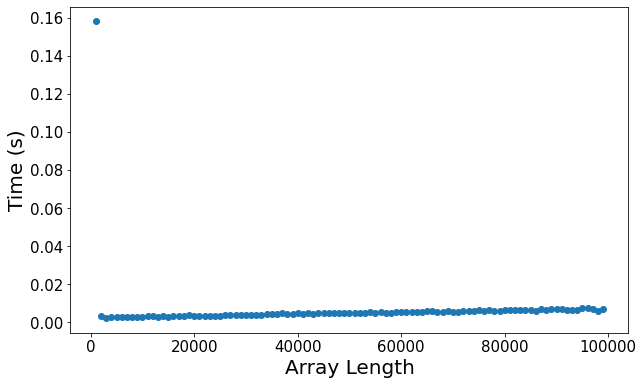

In [5]:
# Plotting GPU times
timesGPU= np.array(timesGPU)
plt.scatter(x=timesGPU[:,0], y=timesGPU[:, 1])
plt.xlabel('Array Length')
plt.ylabel('Time (s)')
plt.show()

## CPU Results
Below the CPU will iterate dF/F calculates from 1000 to 100,000 data points with a step size of 1000. The data was acquired at 2000 Hz and a 150 ms time constant is used to smooth the data with the optional EWMA function.

In [6]:
timesCPU = []
for x in range(1000, 100000, 1000):

    t = time.process_time()
    _dffCPU = CPUFilters.deltaFOverF0(exampleData[:x], 2000, .150)    
    elapsed_time = time.process_time() - t
    timesCPU.append([x, elapsed_time])

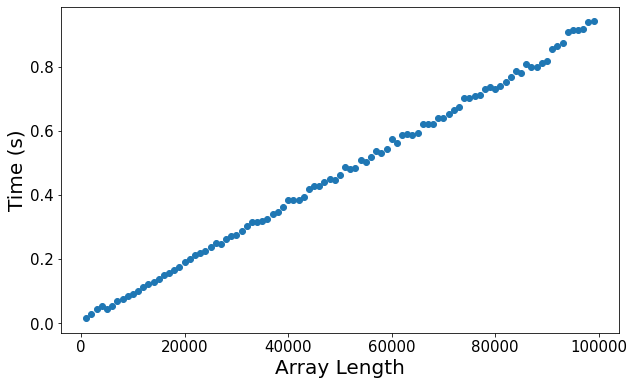

In [7]:
# Plotting CPU times
timesCPU= np.array(timesCPU)
plt.scatter(x=timesCPU[:,0], y=timesCPU[:, 1])
plt.xlabel('Array Length')
plt.ylabel('Time (s)')
plt.show()

## GPU and CPU Comparison

The times for calculating the dF/F values for various array lengths on the CPU and GPU are plotted together using both linear and log scales

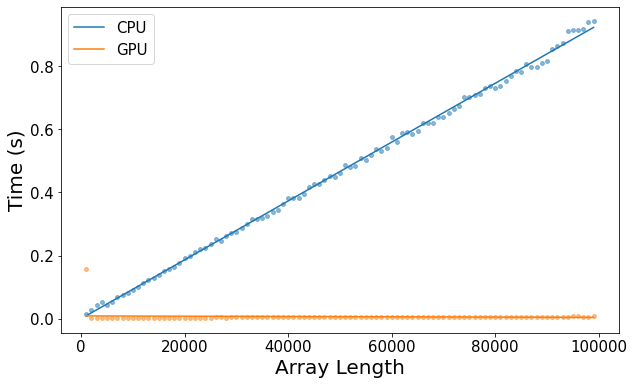

In [8]:
# Plotting the results with lines of best fit on a graph with a linear scale
plt.plot(timesCPU[:,0], np.poly1d(np.polyfit(timesCPU[:,0], timesCPU[:,1], 1))(timesCPU[:,0]))
plt.plot(timesGPU[:,0], np.poly1d(np.polyfit(timesGPU[:,0], timesGPU[:,1], 1))(timesGPU[:,0]))
plt.scatter(x=timesCPU[:,0], y=timesCPU[:, 1], alpha=.5, s=15)
plt.scatter(x=timesGPU[:,0], y=timesGPU[:, 1],alpha=.5, s=15)
plt.legend(labels=['CPU', 'GPU'])
plt.xlabel('Array Length')
plt.ylabel('Time (s)')
plt.show()

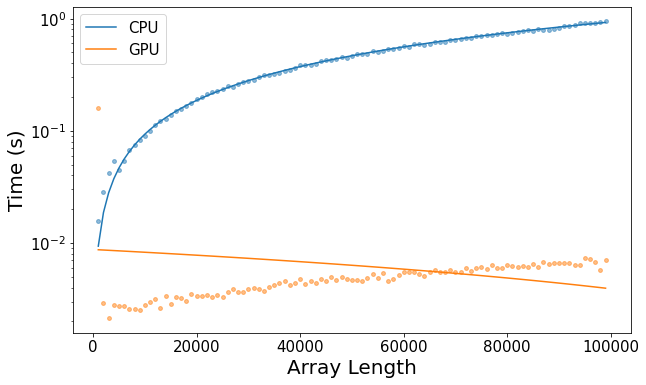

In [9]:
# Plotting the results with lines of best fit on a graph with a log scale
plt.plot(timesCPU[:,0], np.poly1d(np.polyfit(timesCPU[:,0], timesCPU[:,1], 1))(timesCPU[:,0]))
plt.plot(timesGPU[:,0], np.poly1d(np.polyfit(timesGPU[:,0], timesGPU[:,1], 1))(timesGPU[:,0]))
plt.scatter(x=timesCPU[:,0], y=timesCPU[:, 1], alpha=.5, s=15)
plt.scatter(x=timesGPU[:,0], y=timesGPU[:, 1],alpha=.5, s=15)
plt.legend(labels=['CPU', 'GPU'])
plt.xlabel('Array Length')
plt.ylabel('Time (s)')
plt.yscale('log')
plt.show()

## EWMA Comparison
Comparison between the Exponentially Weighted Moving Average (EWMA) and the vectorized approximation used on the GPU. A numpy array of 10,000 random data points are generated and the EWMA is calculated using both methods

In [10]:
randArray = np.random.rand(10000)


hz = 2000
t0 =.05
alphaCPU = np.exp(-1 / (t0 * hz))
alphaGPU = None if t0 is None else 1 - cu.exp(-1 / (t0 * hz))
cpuSmooth = CPUFilters._ewma(randArray, alphaCPU)
gpuSmooth = GPUFilters._ewma(cu.array(randArray), alphaGPU).get()

### Plotting EWMA
The resulting EWMA are plotted over each other with the difference between the CPU and GPU calculations in the adjacent subplot.

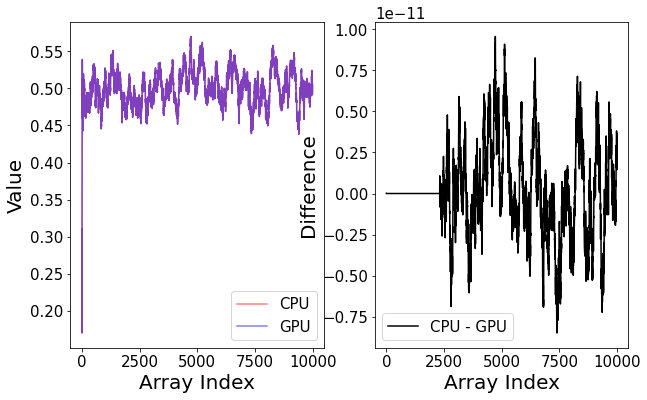

In [11]:

# Create two subplots, one for plotting the EMWA and another for the difference between the GPU and CPU Verisions
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(cpuSmooth, color='red', alpha=.5)
ax1.plot(gpuSmooth, color='blue', alpha=.5)
ax1.legend(labels=['CPU', 'GPU'])
ax1.set_xlabel('Array Index')
ax1.set_ylabel('Value')

# Plotting the difference btween the CPU and GPU calculations
ax2.plot(gpuSmooth-cpuSmooth, color='black')

ax2.legend(labels=['CPU - GPU'])
ax2.set_xlabel('Array Index')
ax2.set_ylabel('Difference')
plt.show()